# 6. Deep Learning for Text and Sequences

## Advanced Use of Recurrent Neural Networks

Here, we introduce three advanced techniques for improving the performance and generalisation power of RNNs. We demonstrate these concepts on a **temperature forecasting** problem, where we have access to timeseries of data points from sensors installed on the roof of a building.

The techniques covered are:
- <b>Recurrent dropout</b> - This is a built-in way to use dropout to fight overfitting in recurrent layers
- <b>Stacking Recurrent Layers</b> - This increases the representational power of the network (at the cost of higher computational loads)
- <b>Bidirectional Recurrent Layers</b> - This present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Flatten, Dense, SimpleRNN, LSTM, GRU)

In the **temperature forecasting** problem, we work with a weather timeseires dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df.iloc[:,1:]
df_values = df.values

In [3]:
# For testing
display(df.head(3))
# print(df.shape)
# print(df.columns)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


This dataset will be used to learn to work with numerical time series. We will use it to build a model that takes in some data in the past as input and predicts the air temperature 24 hours in the future. Each line is a timestep and the readings of the different sensors at that time.

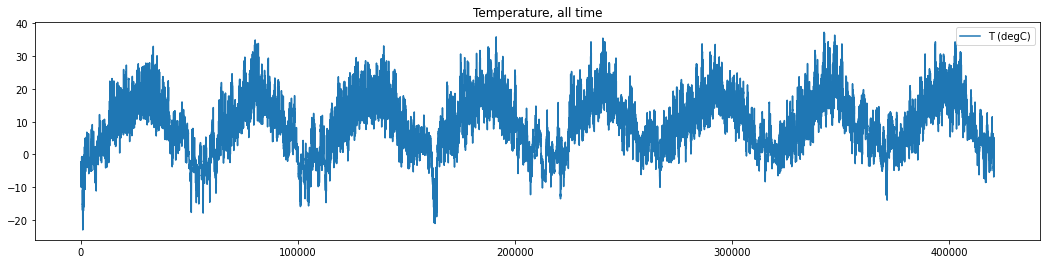

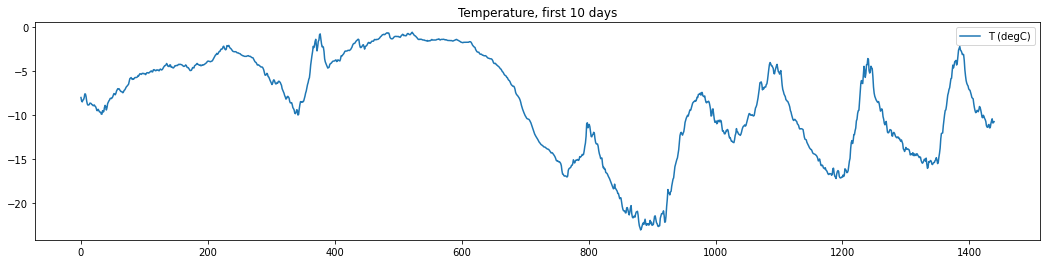

In [4]:
# Plot temperature timeseries for whole period
df.plot(kind='line', y='T (degC)', figsize=(18,4), title="Temperature, all time")
plt.show()
df.iloc[:1440,:].plot(kind='line', y='T (degC)', figsize=(18,4), title="Temperature, first 10 days")
plt.show()

In the 10 days plot, we can see daily periodicity, especially in the last 4 days. Also this is in a cold winter month. If we were trying to predict average temperature for the next month given a few months of past data, the problem would be easy. But looking at the data over a scale of days, the data looks a lot more chaotic. Can we predict time series at a daily scale?

### Problem Statement
The **temperature forecasting** problem is as follows: Given data going as far back as $l$ timesteps, sampled every $f$ steps (that means $n=\frac lf$), can we predict the temperature in $d$ timesteps? E.g. if $l=720, f=6, d=144$, then we have <u>hourly</u> data, up to <u>5 days back</u> (holding <u>120 samples</u>) and want to predict targets <u>24 hours into the future</u>.


In [5]:
# Preprocessing
df_mean, df_std = df_values[:200000].mean(axis=0), df_values[:200000].std(axis=0)
df_values-=df_mean
df_values/=df_std

This generator yields a tuple `(samples, targets)` where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures.

In [6]:
# Generator
def generator(data, lookback=0, delay=0, min_index=0, max_index=None, shuffle=False,
              batch_size=128, step=6):
    '''
    data: the original normalised dataset, containing the features and target
    lookback: how many timesteps the input data should go
    delay: how many timesteps in the future the target should be 
    min_index / max_index: the data array that delimits where to draw from
    shuffle: whether to shuffle the time series data
    batch_size: the number of samples per batch
    step: the period in timesteps to sample the data.
    '''

    # If no max_index is defined, then define
    # it to be the no. of records input
    if max_index == None:
        max_index = len(data) - delay - 1
    
    # earliest observation from the dataset to draw
    i = min_index + lookback
    
    while 1:
        if shuffle:
            # Draw a batch of size (batch_size) from
            # from the dataset, starting from 
            # (min_index+lookback) to max_index
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            # reset i if it exceeds the max_index to draw from
            if i + batch_size >= max_index:
                i = min_index + lookback
            # draw a batch from i to i+batch_size
            rows = np.arange(i, min(i + batch_size, max_index))
            # add this batch to i so the batches are contiguous            
            i+= len(rows)
        
        # create a batch of samples, as a 3D tensor
        # of (num_samples, features)
        # and targets of size rows
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows,)))
        for j, row in enumerate(rows):
            # indices are the steps from low to high
            # with steps
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
LOOKBACK, STEP, DELAY, BATCH_SIZE = 1440, 6, 144, 128
train_min_i, train_max_i = 0, 200000
val_min_i, val_max_i = 200001, 300000
test_min_i, test_max_i = 300001, None
val_steps = (val_max_i - val_min_i - LOOKBACK)
test_steps = (len(df_values) - test_min_i - LOOKBACK)
train_gen = generator(df_values, 
                      lookback=LOOKBACK, delay=DELAY, 
                      min_index=train_min_i, max_index=train_max_i, 
                      batch_size=BATCH_SIZE, step=STEP,shuffle=True)
val_gen = generator(df_values, 
                    lookback=LOOKBACK, delay=DELAY, 
                    min_index=val_min_i, max_index=val_max_i, 
                    batch_size=BATCH_SIZE, step=STEP,shuffle=False)
test_gen = generator(df_values, 
                     lookback=LOOKBACK, delay=DELAY, 
                     min_index=test_min_i, max_index=test_max_i, 
                     batch_size=BATCH_SIZE, step=STEP,shuffle=False)

### Baseline


In [8]:
# def evaluate_naive_method():
#     batch_maes = []
#     for t in range(val_steps):
#         samples, targets = next(val_gen)
#         preds = samples[:,-1,1]
#         mae = np.mean(np.abs(preds - targets))
#         batch_maes.append(mae)
#     print(np.mean(batch_maes))
# evaluate_naive_method()

This yields an MAE of 0.29. it translates to an average error of $0.29 \times \text{std temperature}$ or $2.57^\circ\text{C}$ which is a fairly large training error.

### v1: MLP Model

Before we work on complicated deep learning models, let's use a simple baseline deep learning model. A model with higher complexity should also deliver a proportionate increase in performance.

For this model, let's use 2 `Dense` layers. Note that there is no activation function in the final layer as we are solving a regression problem.

In [9]:
# Instantiate Model
###################
# clear_session()
# model1 = Sequential()
# model1.add(Flatten(input_shape=(LOOKBACK//STEP, df_values.shape[-1])))
# model1.add(Dense(32, activation='relu'))
# model1.add(Dense(1))

# Compile
#########
# model1.compile(optimizer=RMSprop(), loss='mae',)
# print(model1.summary())

# Train
#######
# history1 = model1.fit(train_gen, steps_per_epoch=500, epochs=20, 
#                       validation_data=val_gen, validation_steps=val_steps)

In [10]:
# Load trained model. 
# Ran on EC2 Medium for 18 hours
# Code: weather_modelv1_mlp.py
################################
clear_session()
model1 = load_model('weather__v1__mlp.h5')

In [11]:
# model1.predict(generator(df_values, 
#                      lookback=LOOKBACK, delay=DELAY, 
#                      min_index=300000, max_index=310000, 
#                      batch_size=BATCH_SIZE, step=STEP,shuffle=False))

,loss,val_loss,epoch
15,0.207683,0.322443,16
16,0.206338,0.327836,17
17,0.203756,0.334344,18
18,0.202211,0.335350,19
19,0.200439,0.318153,20


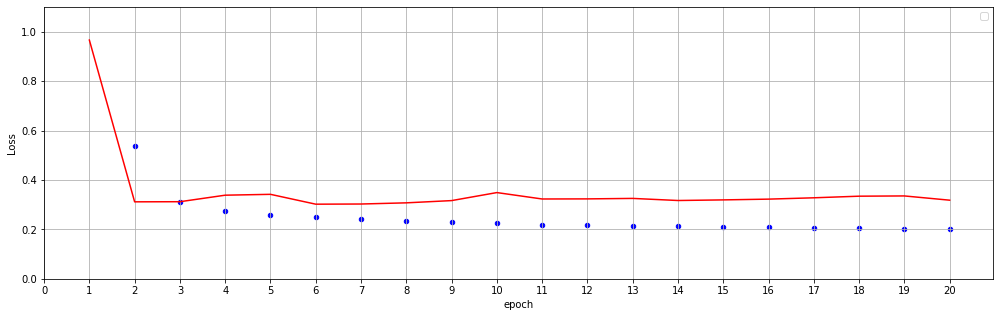

In [12]:
# Evaluate
##########
# metrics_df = pd.DataFrame(history1.history)

# Load History of trained model.
# weather_modelv1_mlp.py
################################
metrics_df = pd.read_csv('weather__v1history__mlp.csv')
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,1,1)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,metrics_df.shape[0]+1))
plt.show()

### v2.1: Recurrent Baseline

The MLP model flattened the time series, which removed the notion of time from the input data. Let's look at the data as what it is: a sequence, where order matters. We will use a recurrent-sequence processing model.

This time, we will use the Gated recurrent unit (`GRU`) layer. They use the same principle as LSTM, but are somewhat streamlined and thus cheaper to run (and might not have the same representational power as LSTM). This is a classical tradeoff in ML in the industry.

In [ ]:
# Instantiate Model
###################
# clear_session()
# model2 = Sequential()
# model2.add(GRU(32, input_shape=(None, df_values.shape[-1])))
# model2.add(Dense(1))

# Compile
#########
# model2.compile(optimizer=RMSprop(), loss='mae',)
# print(model2.summary())

# Train
#######
# history2 = model2.fit(train_gen, steps_per_epoch=500, epochs=20, 
#                       validation_data=val_gen, validation_steps=val_steps)

In [ ]:
# Load trained model. 
# Ran on EC2 Medium for 2 days
# Code: weather_modelv2_rnn.py
################################

,loss,val_loss,epoch
15,0.215189,0.294299,16
16,0.211771,0.290098,17
17,0.209199,0.297865,18
18,0.205123,0.298661,19
19,0.202315,0.303692,20


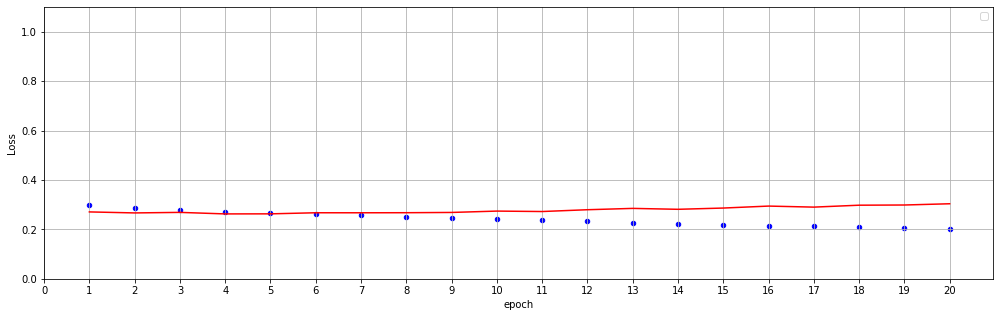

In [3]:
# Evaluate
##########
# metrics_df = pd.DataFrame(history1.history)

# Load History of trained model.
# weather_modelv1_mlp.py
################################
metrics_df = pd.read_csv('weather__v2history__rnn.csv')
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,1,1)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,metrics_df.shape[0]+1))
plt.show()

It's clear that this model has beaten the MLP baseline.

### v2.2: RNN with Dropout
One of the ways to overcome overfitting is by using dropout, which randomly zeros out input units of a layer to break coincidental correlations in the training data that the layer is exposed to. 

However, appplying dropout in a reucurrent layer isn't a trivial question. Applying dropout before a recurrent layer hinders learning rahter than helping with regularization. In Yarin Gal's [thesis](http://mlg.eng.cam.ac.uk/yarin/blog_2248.html), the proper way to use dropout is to use the same dropout mask (pattern of dropped units) at every timestep, instead of a dropout mask that varies randomly from timestep to timestep. Also, in order to regularise the representations formed by the recurrent gates of layers, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer. Using the same dropout mask at every timestep allows the network to properly proagate its learning error through time.

This dropout behaviour can be implemented using 2 parameters: `dropout` specifying the dropout rate for input units of the layer and `recurrent_dropout`, specifying the dropout rate of teh recurrent units.

In [ ]:
# Instantiate Model
###################
# clear_session()
# model3 = Sequential()
# model3.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, 
#                input_shape=(None, df_values.shape[-1])))
# model3.add(Dense(1))

# Compile
#########
# model3.compile(optimizer=RMSprop(), loss='mae',)
# print(model3.summary())

# Train
#######
# history3 = model3.fit(train_gen, 
#   steps_per_epoch=500, 
#   epochs=40, 
#   validation_data=val_gen, 
#   validation_steps=val_steps)

In [ ]:
# Evaluate
##########
# metrics_df = pd.DataFrame(history1.history)

# Load History of trained model.
# X.py
################################
# metrics_df = pd.read_csv('weather__v1history__mlp.csv')
# metrics_df['epoch'] = metrics_df.index+1
# display(metrics_df.tail())

# fig = plt.figure(figsize=(17,5))
# ax1 = fig.add_subplot(1,1,1)
# metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
# metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
# ax1.set_ylabel("Loss")
# ax1.grid('GAINSBORO')
# ax1.legend([])
# ax1.set_ylim(0,1.1)
# ax1.set_xticks(range(0,metrics_df.shape[0]+1))
# plt.show()

### v2.3: Stacking RNN Layers

The next step is to increase the capacity of the network. As long as you re not overfitting too badly, you're likely under capacity. The low network capacity might not maximise the model's performance (in this case, validation accuracy).

Increasing a network's capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks. For example, the model powering Google Translate is a stack of seven large LSTM layers.

When recurrent layers are stacked on top of each other in Keras, all intermediate layers should return their full sequence of outputs rather than the output at the last timestep.

In [ ]:
# Instantiate Model
###################
# clear_session()
# model4 = Sequential()
# model4.add(GRU(32, dropout=0.1, recurrent_dropout=0.5,
#                return_sequences=True,
#                input_shape=(None, df_values.shape[-1])))
# model4.add(GRU(64, activation='relu', dropout=0.1, 
#                recurrent_dropout=0.5))
# model4.add(Dense(1))

# Compile
#########
# model4.compile(optimizer=RMSprop(), loss='mae',)
# print(model4.summary())

# Train
#######
# history4 = model4.fit(train_gen, 
#   steps_per_epoch=500, 
#   epochs=40, 
#   validation_data=val_gen, 
#   validation_steps=val_steps)

### v2.4: Using Bidirectional RNN

A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It is frequently used in natural language processing. 

RNNs are order dependent or time dependent: they process the input sequences in order and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely why they perform well on problems where the order is meaningful.

A birectional RNN explots the order sensitivity of RNNs. It uses 2 regular RNN layers and each process the input sequences in one direction, and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.